In [8]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

NLP From Scratch: Generating Names with a Character-Level RNN
=============================================================

**Author**: [Sean Robertson](https://github.com/spro)

This tutorials is part of a three-part series:

-   [NLP From Scratch: Classifying Names with a Character-Level
    RNN](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
-   [NLP From Scratch: Generating Names with a Character-Level
    RNN](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html)
-   [NLP From Scratch: Translation with a Sequence to Sequence Network
    and
    Attention](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

This is our second of three tutorials on \"NLP From Scratch\". In the
[first
tutorial](/tutorials/intermediate/char_rnn_classification_tutorial) we
used a RNN to classify names into their language of origin. This time
we\'ll turn around and generate names from languages.

``` {.sh}
> python sample.py Russian RUS
Rovakov
Uantov
Shavakov

> python sample.py German GER
Gerren
Ereng
Rosher

> python sample.py Spanish SPA
Salla
Parer
Allan

> python sample.py Chinese CHI
Chan
Hang
Iun
```

We are still hand-crafting a small RNN with a few linear layers. The big
difference is instead of predicting a category after reading in all the
letters of a name, we input a category and output one letter at a time.
Recurrently predicting characters to form language (this could also be
done with words or other higher order constructs) is often referred to
as a \"language model\".

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-   <https://pytorch.org/> For installation instructions
-   `/beginner/deep_learning_60min_blitz`{.interpreted-text role="doc"}
    to get started with PyTorch in general
-   `/beginner/pytorch_with_examples`{.interpreted-text role="doc"} for
    a wide and deep overview
-   `/beginner/former_torchies_tutorial`{.interpreted-text role="doc"}
    if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-   [The Unreasonable Effectiveness of Recurrent Neural
    Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)
    shows a bunch of real life examples
-   [Understanding LSTM
    Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
    is about LSTMs specifically but also informative about RNNs in
    general

I also suggest the previous tutorial,
`/intermediate/char_rnn_classification_tutorial`{.interpreted-text
role="doc"}

Preparing the Data
------------------

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p>Download the data from<a href="https://download.pytorch.org/tutorial/data.zip">here</a>and extract it to the current directory.</p>

</div>

See the last tutorial for more detail of this process. In short, there
are a bunch of plain text files `data/names/[Language].txt` with a name
per line. We split lines into an array, convert Unicode to ASCII, and
end up with a dictionary `{language: [names ...]}`.


In [9]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


Creating the Network
====================

This network extends [the last tutorial\'s RNN](#Creating-the-Network)
with an extra argument for the category tensor, which is concatenated
along with the others. The category tensor is a one-hot vector just like
the letter input.

We will interpret the output as the probability of the next letter. When
sampling, the most likely output letter is used as the next input
letter.

I added a second linear layer `o2o` (after combining hidden and output)
to give it more muscle to work with. There\'s also a dropout layer,
which [randomly zeros parts of its
input](https://arxiv.org/abs/1207.0580) with a given probability (here
0.1) and is usually used to fuzz inputs to prevent overfitting. Here
we\'re using it towards the end of the network to purposely add some
chaos and increase sampling variety.

![](https://i.imgur.com/jzVrf7f.png)


In [10]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

Training
========

Preparing for Training
----------------------

First of all, helper functions to get random pairs of (category, line):


In [11]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

For each timestep (that is, for each letter in a training word) the
inputs of the network will be `(category, current letter, hidden state)`
and the outputs will be `(next letter, next hidden state)`. So for each
training set, we\'ll need the category, a set of input letters, and a
set of output/target letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for `"ABCD<EOS>"` we would create (\"A\", \"B\"), (\"B\",
\"C\"), (\"C\", \"D\"), (\"D\", \"EOS\").

![](https://i.imgur.com/JH58tXY.png)

The category tensor is a [one-hot
tensor](https://en.wikipedia.org/wiki/One-hot) of size
`<1 x n_categories>`. When training we feed it to the network at every
timestep - this is a design choice, it could have been included as part
of initial hidden state or some other strategy.


In [12]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

For convenience during training we\'ll make a `randomTrainingExample`
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.


In [13]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

Training the Network
====================

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.


In [14]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

To keep track of how long training takes I am adding a
`timeSince(timestamp)` function which returns a human readable string:


In [15]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a
few minutes, printing the current time and loss every `print_every`
examples, and keeping store of an average loss per `plot_every` examples
in `all_losses` for plotting later.


In [16]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 14s (5000 5%) 2.6033
0m 27s (10000 10%) 3.1413
0m 40s (15000 15%) 2.3091
0m 54s (20000 20%) 2.7310
1m 7s (25000 25%) 2.6151
1m 20s (30000 30%) 2.1476
1m 33s (35000 35%) 2.0768
1m 47s (40000 40%) 1.6614
2m 0s (45000 45%) 2.0579
2m 13s (50000 50%) 2.2094
2m 26s (55000 55%) 2.0366
2m 40s (60000 60%) 2.5838
2m 53s (65000 65%) 1.5349
3m 6s (70000 70%) 2.1711
3m 19s (75000 75%) 2.2630
3m 32s (80000 80%) 3.7600
3m 45s (85000 85%) 1.4449
3m 59s (90000 90%) 3.2641
4m 12s (95000 95%) 2.0435
4m 25s (100000 100%) 3.1490


Plotting the Losses
===================

Plotting the historical loss from all\_losses shows the network
learning:


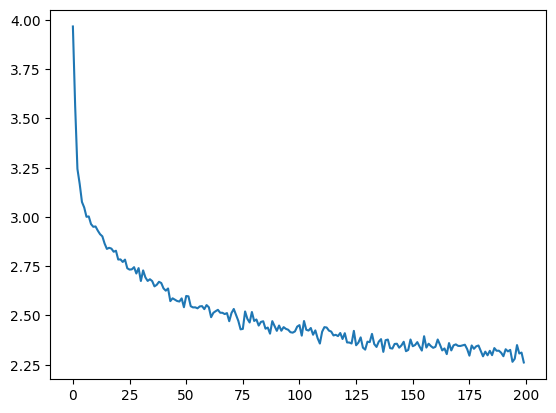

In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

Sampling the Network
====================

To sample we give the network a letter and ask what the next one is,
feed that in as the next letter, and repeat until the EOS token.

-   Create tensors for input category, starting letter, and empty hidden
    state
-   Create a string `output_name` with the starting letter
-   Up to a maximum output length,
    -   Feed the current letter to the network
    -   Get the next letter from highest output, and next hidden state
    -   If the letter is EOS, stop here
    -   If a regular letter, add to `output_name` and continue
-   Return the final name

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p>Rather than having to give it a starting letter, anotherstrategy would have been to include a "start of string" token intraining and have the network choose its own starting letter.</p>

</div>



In [18]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rovaki
Uanderiki
Shavaki
Gerre
Eren
Rerter
Salla
Pares
Allan
Cha
Hang
Iun


Exercises
=========

-   Try with a different dataset of category -\> line, for example:
    -   Fictional series -\> Character name
    -   Part of speech -\> Word
    -   Country -\> City
-   Use a \"start of sentence\" token so that sampling can be done
    without choosing a start letter
-   Get better results with a bigger and/or better shaped network
    -   Try the `nn.LSTM` and `nn.GRU` layers
    -   Combine multiple of these RNNs as a higher level network


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import string
import random
import unicodedata # Для функції unicodeToAscii, якщо потрібна для нових даних

# --- Вправа 1: Спробувати з іншим набором даних ---
data = {
    'Ukraine': ['Kyiv', 'Lviv', 'Odessa', 'Kharkiv', 'Dnipro'],
    'USA': ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Miami'],
    'Japan': ['Tokyo', 'Osaka', 'Kyoto', 'Nagoya', 'Sapporo']
}


In [40]:
# --- Допоміжна функція для очищення рядків (з оригінального ноутбука) ---
# Якщо ваші дані не потребують очищення, цю частину можна спростити або видалити.
# Наразі вона не використовується активно з прикладом "Fictional series", але залишена для гнучкості.
all_base_letters_for_ascii = string.ascii_letters + " .,;'-"
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_base_letters_for_ascii # Перевірка наявності в базових символах
    )


In [41]:
# --- Клас для управління словником символів (рефакторинг з попередньої відповіді) ---
class CharVocabulary:
    def __init__(self, base_chars: str, sos_token: str = '<SOS>', eos_token: str = '<EOS>'):
        self.sos_token = sos_token
        self.eos_token = eos_token
        # --- Вправа 2: Використання токенів "start of sentence" ---
        # <SOS> та <EOS> додаються до словника
        unique_chars = set(base_chars)
        self.all_letters_list = [self.sos_token, self.eos_token] + sorted(list(unique_chars))
        self.n_letters = len(self.all_letters_list)

        self.char2idx = {ch: i for i, ch in enumerate(self.all_letters_list)}
        self.idx2char = {i: ch for i, ch in self.char2idx.items()}

    def line_to_tensor(self, line: str) -> torch.Tensor:
        indices = [self.char2idx[self.sos_token]]
        for ch in line:
            if ch in self.char2idx: # Ігнорувати символи, яких немає в словнику
                indices.append(self.char2idx[ch])
        indices.append(self.char2idx[self.eos_token])
        return torch.tensor(indices, dtype=torch.long)

    def tensor_to_line(self, tensor: torch.Tensor) -> str:
        chars = []
        indices = tensor.squeeze().tolist() if tensor.dim() > 0 else [tensor.item()]
        for idx_val in indices: # Змінено idx на idx_val, щоб уникнути конфлікту
            char = self.idx2char.get(idx_val)
            if char is None or char == self.sos_token:
                continue
            if char == self.eos_token:
                break
            chars.append(char)
        return "".join(chars)

# Створення словника на основі всіх символів у наданих даних
all_chars_in_data = set()
for category_lines in data.values():
    for line in category_lines:
        # line_cleaned = unicodeToAscii(line) # Розкоментуйте, якщо потрібне очищення
        line_cleaned = line # Для прикладу "Fictional series" очищення не критичне
        for char_ in line_cleaned: # Змінено char на char_
            all_chars_in_data.add(char_)

vocabulary = CharVocabulary("".join(sorted(list(all_chars_in_data))))
n_letters = vocabulary.n_letters
all_categories = list(data.keys())
n_categories = len(all_categories)

In [42]:
# --- Вправа 3: Краща мережа (LSTM/GRU, кілька шарів) ---
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,
                 n_categories_param, n_layers=2, rnn_type='LSTM', dropout=0.2): # n_categories перейменовано на n_categories_param
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_categories = n_categories_param # Використання перейменованого параметра

        self.encoder = nn.Embedding(input_size, hidden_size)
        
        rnn_input_size = hidden_size + self.n_categories # Вхід для RNN включає категорію

        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(rnn_input_size, hidden_size, n_layers, dropout=dropout if n_layers > 1 else 0, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(rnn_input_size, hidden_size, n_layers, dropout=dropout if n_layers > 1 else 0, batch_first=True)
        else:
            raise ValueError("Unsupported RNN type. Choose 'LSTM' or 'GRU'.")
        
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, category_idx_tensor, input_char_tensor, hidden_state):
        # Вбудовування символу
        # input_char_tensor має бути [batch_size=1, seq_len=1]
        embedded = self.encoder(input_char_tensor) # -> [1, 1, hidden_size]

        # Створення one-hot для категорії та розширення
        # category_idx_tensor має бути скаляром або [1]
        category_one_hot = torch.zeros(1, 1, self.n_categories) # batch_first=True, тому [batch, seq, features]
        category_one_hot[0, 0, category_idx_tensor.item()] = 1.0
        
        # Розширення one-hot категорії до розміру ембеддінга (якщо потрібно, але тут вже [1,1,N])
        # category_one_hot = category_one_hot.expand(1, 1, self.n_categories) # Вже правильний розмір

        # Конкатенація ембеддінга символу та категорії
        combined_input = torch.cat((embedded, category_one_hot), dim=2) # -> [1, 1, hidden_size + n_categories]
        
        output, hidden_state = self.rnn(combined_input, hidden_state)
        
        # Декодування
        # output від RNN: [batch_size=1, seq_len=1, hidden_size]
        output = self.decoder(output.squeeze(1)) # -> [1, output_size]
        return output, hidden_state

    def init_hidden(self, batch_size=1): # Додано batch_size для гнучкості, хоча тут завжди 1
        weight = next(self.parameters()).data
        if isinstance(self.rnn, nn.LSTM):
            return (weight.new(self.n_layers, batch_size, self.hidden_size).zero_(),
                    weight.new(self.n_layers, batch_size, self.hidden_size).zero_())
        else: # GRU
            return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()

In [43]:
# --- Параметри тренування та моделі ---
# Спробуйте змінити ці параметри для експериментів
HIDDEN_SIZE = 128       # Розмір прихованого стану (частина вправи 3 - "bigger network")
N_LAYERS = 2            # Кількість шарів RNN (частина вправи 3 - "combine multiple RNNs")
RNN_TYPE = 'LSTM'       # Тип RNN: 'LSTM' або 'GRU' (частина вправи 3)
LEARNING_RATE = 0.005
N_ITERS = 20000         # Кількість ітерацій тренування
PRINT_EVERY = 1000
CLIP = 1.0 # Градієнтний кліппінг для стабільності

model = CharRNN(
    input_size=n_letters,
    hidden_size=HIDDEN_SIZE,
    output_size=n_letters,
    n_categories_param=n_categories, # Передача правильного параметра
    n_layers=N_LAYERS,
    rnn_type=RNN_TYPE,
    dropout=0.1 if N_LAYERS > 1 else 0 # Dropout тільки якщо більше 1 шару
)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [44]:
# --- Функція тренування одного кроку ---
def train_step(category_name, line_text):
    model.train() # Переведення моделі в режим тренування
    
    category_idx = all_categories.index(category_name)
    category_tensor = torch.tensor([category_idx], dtype=torch.long)
    
    line_tensor = vocabulary.line_to_tensor(line_text)
    
    # Вхід: всі символи, крім останнього (<EOS>)
    # Ціль: всі символи, крім першого (<SOS>)
    input_line_tensor = line_tensor[:-1]
    target_line_tensor = line_tensor[1:]

    hidden = model.init_hidden()
    optimizer.zero_grad()
    loss = 0

    for i in range(input_line_tensor.size(0)):
        # Передача одного символу за раз
        # Вхід для моделі: (індекс категорії, тензор поточного символу, прихований стан)
        # input_char_tensor має бути [1, 1] для batch_first=True
        output, hidden = model(category_tensor, input_line_tensor[i].unsqueeze(0).unsqueeze(0), hidden)
        # output: [1, n_letters], target_line_tensor[i] має бути скаляром для CrossEntropyLoss
        loss += criterion(output, target_line_tensor[i].unsqueeze(0))

    loss.backward()
    
    # Градієнтний кліппінг
    torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
    
    optimizer.step()
    return loss.item() / input_line_tensor.size(0) # Середня втрата на символ

In [45]:
# --- Функція тренування одного кроку ---
def train_step(category_name, line_text):
    model.train() # Переведення моделі в режим тренування
    
    category_idx = all_categories.index(category_name)
    category_tensor = torch.tensor([category_idx], dtype=torch.long)
    
    line_tensor = vocabulary.line_to_tensor(line_text)
    
    # Вхід: всі символи, крім останнього (<EOS>)
    # Ціль: всі символи, крім першого (<SOS>)
    input_line_tensor = line_tensor[:-1]
    target_line_tensor = line_tensor[1:]

    hidden = model.init_hidden()
    optimizer.zero_grad()
    loss = 0

    for i in range(input_line_tensor.size(0)):
        # Передача одного символу за раз
        # Вхід для моделі: (індекс категорії, тензор поточного символу, прихований стан)
        # input_char_tensor має бути [1, 1] для batch_first=True
        output, hidden = model(category_tensor, input_line_tensor[i].unsqueeze(0).unsqueeze(0), hidden)
        # output: [1, n_letters], target_line_tensor[i] має бути скаляром для CrossEntropyLoss
        loss += criterion(output, target_line_tensor[i].unsqueeze(0))

    loss.backward()
    
    # Градієнтний кліппінг
    torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
    
    optimizer.step()
    return loss.item() / input_line_tensor.size(0) # Середня втрата на символ

In [46]:
# --- Цикл тренування ---
print(f"Training with {RNN_TYPE}, {N_LAYERS} layers, hidden_size={HIDDEN_SIZE}...")
current_loss = 0
all_losses = []

for iter_num in range(1, N_ITERS + 1):
    # Випадковий вибір категорії та рядка
    category_sample = random.choice(all_categories)
    line_sample = random.choice(data[category_sample])
    # line_sample_cleaned = unicodeToAscii(line_sample) # Розкоментуйте, якщо потрібне очищення
    line_sample_cleaned = line_sample

    loss = train_step(category_sample, line_sample_cleaned)
    current_loss += loss

    if iter_num % PRINT_EVERY == 0:
        avg_loss = current_loss / PRINT_EVERY
        all_losses.append(avg_loss)
        print(f'Iter: {iter_num}/{N_ITERS} ({iter_num / N_ITERS * 100:.0f}%) Loss: {avg_loss:.4f}')
        current_loss = 0

Training with LSTM, 2 layers, hidden_size=128...
Iter: 1000/20000 (5%) Loss: 0.6717
Iter: 2000/20000 (10%) Loss: 0.3440
Iter: 3000/20000 (15%) Loss: 0.2581
Iter: 4000/20000 (20%) Loss: 0.2514
Iter: 5000/20000 (25%) Loss: 0.2511
Iter: 6000/20000 (30%) Loss: 0.3208
Iter: 7000/20000 (35%) Loss: 0.2490
Iter: 8000/20000 (40%) Loss: 0.2474
Iter: 9000/20000 (45%) Loss: 0.2450
Iter: 10000/20000 (50%) Loss: 0.2427
Iter: 11000/20000 (55%) Loss: 0.2433
Iter: 12000/20000 (60%) Loss: 0.2451
Iter: 13000/20000 (65%) Loss: 0.2428
Iter: 14000/20000 (70%) Loss: 0.2442
Iter: 15000/20000 (75%) Loss: 0.2430
Iter: 16000/20000 (80%) Loss: 0.2689
Iter: 17000/20000 (85%) Loss: 0.2452
Iter: 18000/20000 (90%) Loss: 0.2398
Iter: 19000/20000 (95%) Loss: 0.2438
Iter: 20000/20000 (100%) Loss: 0.2422


In [50]:
# --- Функція семплінгу (генерації) ---
def sample(category_name, start_letter=None, max_length=20):
    model.eval() # Переведення моделі в режим оцінки
    with torch.no_grad():
        category_idx = all_categories.index(category_name)
        category_tensor = torch.tensor([category_idx], dtype=torch.long)

        # --- Вправа 2: Семплінг без вибору першої літери (починаємо з SOS) ---
        if start_letter is None:
            current_char_idx = vocabulary.char2idx[vocabulary.sos_token]
            output_name = [] # Не додаємо SOS до вихідного рядка
        else:
            if start_letter not in vocabulary.char2idx:
                print(f"Warning: Start letter '{start_letter}' not in vocabulary. Using SOS.")
                current_char_idx = vocabulary.char2idx[vocabulary.sos_token]
                output_name = []
            else:
                current_char_idx = vocabulary.char2idx[start_letter]
                output_name = [start_letter]
        
        input_char_tensor = torch.tensor([[current_char_idx]], dtype=torch.long) # [1,1]
        hidden = model.init_hidden()
        
        for _ in range(max_length):
            output, hidden = model(category_tensor, input_char_tensor, hidden)
            
            # Отримання найбільш ймовірного наступного символу
            topv, topi = output.topk(1)
            next_char_idx = topi.squeeze().item()

            # Перевірка, чи індекс в межах словника перед доступом
            if next_char_idx not in vocabulary.idx2char:
                print(f"Warning: Predicted index {next_char_idx} is out of vocabulary bounds (max: {vocabulary.n_letters -1}). Stopping generation.")
                break # Зупинити генерацію, якщо індекс поза межами

            if next_char_idx == vocabulary.char2idx[vocabulary.eos_token]:
                break
            
            next_char = vocabulary.idx2char[next_char_idx]
            output_name.append(next_char)
            
            current_char_idx = next_char_idx
            input_char_tensor = torch.tensor([[current_char_idx]], dtype=torch.long)

        return "".join(output_name)


Sampling results:

== Ukraine ==





Starting with 'A': A

== USA ==





Starting with 'A': A

== Japan ==





Starting with 'A': A


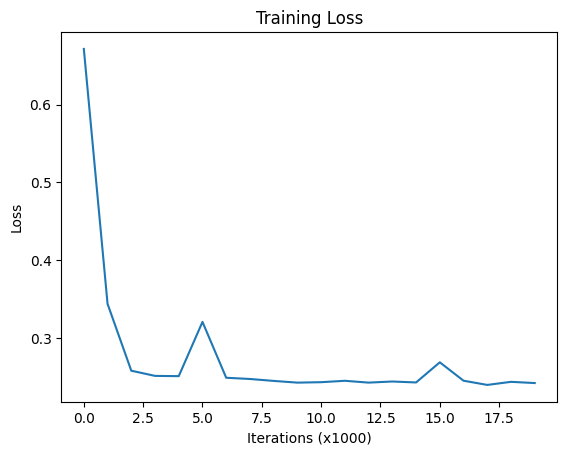


Script finished.


In [51]:
# --- Семплінг після тренування ---
print("\nSampling results:")
for category_to_sample in all_categories:
    print(f"\n== {category_to_sample} ==")
    for _ in range(5): # Згенерувати 5 прикладів для кожної категорії
        # Починаємо з SOS (start_letter=None)
        generated_name = sample(category_to_sample, start_letter=None) 
        print(generated_name)
    # Можна також спробувати з конкретною першою літерою:
    print(f"Starting with 'A': {sample(category_to_sample, start_letter='A')}")



import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_losses)
plt.title("Training Loss")
plt.xlabel(f"Iterations (x{PRINT_EVERY})")
plt.ylabel("Loss")
plt.show()

print("\nScript finished.")


Starting LSTM experiment
LSTM iter 600/3000 loss=0.2628
LSTM iter 1200/3000 loss=0.0421
LSTM iter 1800/3000 loss=0.0169
LSTM iter 2400/3000 loss=0.0068
LSTM iter 3000/3000 loss=0.0037


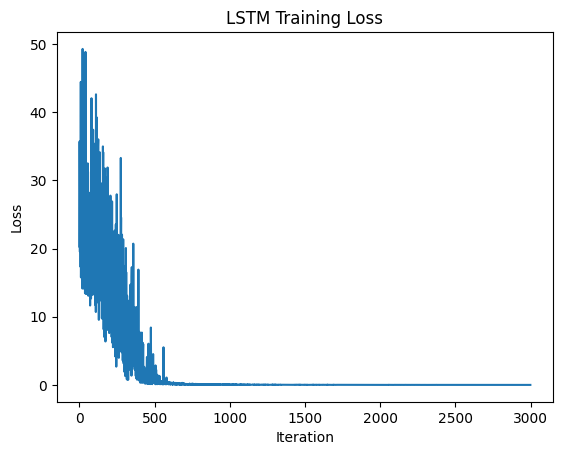


Samples for LSTM:
Thailand -> Bangkok
Greece -> Athens
Argentina -> Buenos Aires
Italy -> Rome
Ukraine -> Kyiv


Starting GRU experiment
GRU iter 600/3000 loss=0.0546
GRU iter 1200/3000 loss=0.0089
GRU iter 1800/3000 loss=0.0096
GRU iter 2400/3000 loss=0.0064
GRU iter 3000/3000 loss=0.0024


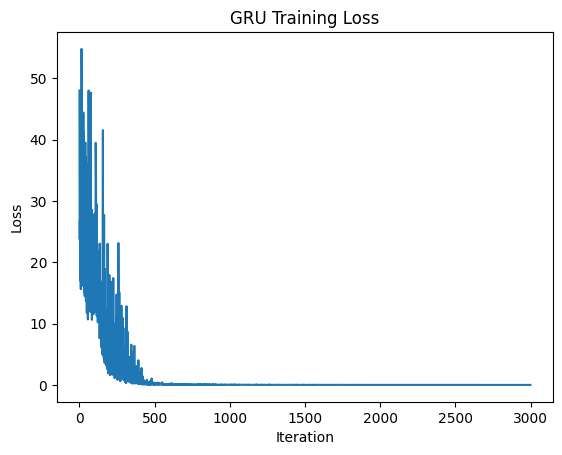


Samples for GRU:
Norway -> Oslo
India -> New Delhi
Germany -> Berlin
Brazil -> Bras
Thailand -> Bangkok


Starting RNN experiment
RNN iter 600/3000 loss=2.1737
RNN iter 1200/3000 loss=0.0854
RNN iter 1800/3000 loss=0.0304
RNN iter 2400/3000 loss=0.0072
RNN iter 3000/3000 loss=0.0112


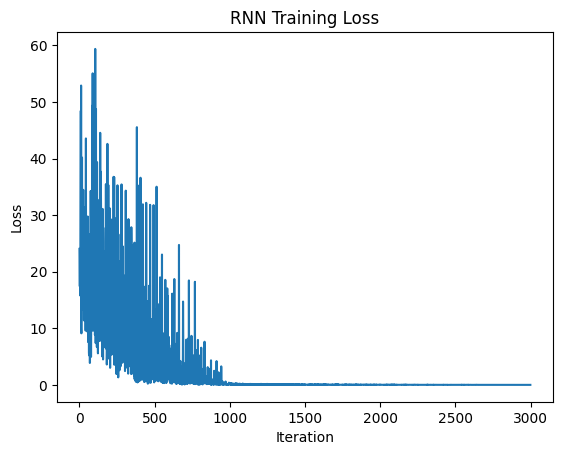


Samples for RNN:
Sweden -> Stockholm
Spain -> Madrid
Italy -> Rome
Kenya -> Nairobi
China -> Beijing


Starting Stacked experiment
Stacked iter 600/3000 loss=0.1180
Stacked iter 1200/3000 loss=0.0110
Stacked iter 1800/3000 loss=0.0052
Stacked iter 2400/3000 loss=0.0032
Stacked iter 3000/3000 loss=0.0019


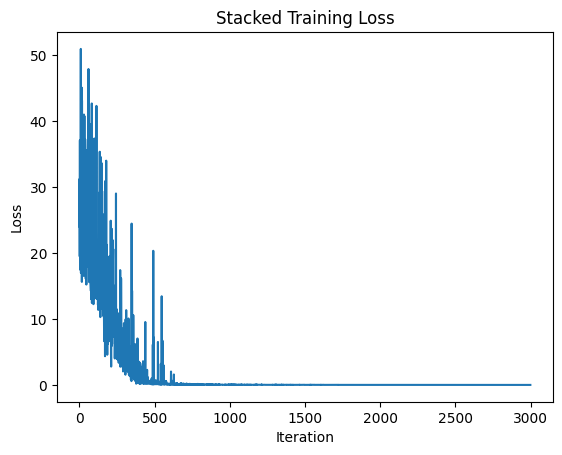


Samples for Stacked:
Turkey -> Ankara
Japan -> Tokyo
China -> Beijing
Canada -> Ottawa
France -> Paris




In [59]:
import torch
import torch.nn as nn
import random
import string
import matplotlib.pyplot as plt

# =============================
# 1. Dataset: Country -> Capital City
# =============================
country_to_city = {
    "France": "Paris", "Japan": "Tokyo", "Brazil": "Brasília", "Egypt": "Cairo",
    "Germany": "Berlin", "Italy": "Rome", "Canada": "Ottawa", "India": "New Delhi",
    "Australia": "Canberra", "Ukraine": "Kyiv", "Spain": "Madrid", "Mexico": "Mexico City",
    "China": "Beijing", "Turkey": "Ankara", "Argentina": "Buenos Aires", "Kenya": "Nairobi",
    "Norway": "Oslo", "Sweden": "Stockholm", "Greece": "Athens", "Thailand": "Bangkok"
}
categories = list(country_to_city.keys())

# =============================
# 2. Character Set + Special Tokens
# =============================
all_letters = string.ascii_letters + " -"
SOS_token = 0
EOS_token = 1
letter_list = list(all_letters)
n_letters = len(letter_list) + 2  # + SOS, EOS
n_categories = len(categories)

# Mappings
letter_to_idx = {ch: i+2 for i, ch in enumerate(letter_list)}
idx_to_letter = {i+2: ch for i, ch in enumerate(letter_list)}
idx_to_letter[SOS_token] = '<SOS>'
idx_to_letter[EOS_token] = '<EOS>'

category_to_idx = {cat: i for i, cat in enumerate(categories)}

# =============================
# 3. Tensor conversion helpers
# =============================
def letter_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0, letter_to_idx.get(letter, EOS_token)] = 1
    return tensor

def category_tensor(cat):
    tensor = torch.zeros(1, n_categories)
    tensor[0, category_to_idx[cat]] = 1
    return tensor

def line_tensors(line):
    inputs = [letter_tensor('<SOS>')]
    for ch in line:
        inputs.append(letter_tensor(ch))
    inputs.append(letter_tensor('<EOS>'))
    return inputs[:-1], inputs[1:]

# =============================
# 4. RNN Model Variants
# =============================
class CharRNN(nn.Module):
    def __init__(self, rnn_type='LSTM', input_size=n_letters+n_categories,
                 hidden_size=128, output_size=n_letters, num_layers=2):
        super().__init__()
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers)
        else:
            self.rnn = nn.RNN(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size

    def forward(self, inp, hidden):
        out, hidden = self.rnn(inp, hidden)
        out = self.fc(out.squeeze(0))
        return out, hidden

    def init_hidden(self):
        weight = next(self.parameters())
        if self.rnn_type == 'LSTM':
            return (weight.new_zeros(self.num_layers, 1, self.hidden_size),
                    weight.new_zeros(self.num_layers, 1, self.hidden_size))
        else:
            return weight.new_zeros(self.num_layers, 1, self.hidden_size)

# =============================
# 5. Training Function for Simple RNNs
# =============================
def train(model, category, line, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    hidden = model.init_hidden()
    inp_seq, tgt_seq = line_tensors(line)
    loss = 0
    for inp, tgt in zip(inp_seq, tgt_seq):
        combined = torch.cat([inp, category_tensor(category)], dim=1)
        output, hidden = model(combined.unsqueeze(0), hidden)
        loss += criterion(output, tgt.argmax(dim=1))
    loss.backward()
    optimizer.step()
    return loss.item()

# =============================
# 6. Sampling Function
# =============================
def sample(model, category, max_len=20):
    model.eval()
    hidden = model.init_hidden()
    inp = letter_tensor('<SOS>')
    name = ''
    with torch.no_grad():
        for _ in range(max_len):
            combined = torch.cat([inp, category_tensor(category)], dim=1)
            output, hidden = model(combined.unsqueeze(0), hidden)
            top_i = output.argmax(dim=1).item()
            if top_i == EOS_token:
                break
            ch = idx_to_letter[top_i]
            name += ch
            inp = letter_tensor(ch)
    return name

# =============================
# 7. Stacked RNN: LSTM followed by GRU
# =============================
class StackedRNN(nn.Module):
    def __init__(self, input_size=n_letters+n_categories, hidden_size=128, output_size=n_letters):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=1)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, inp, hidden):
        (h_l, c_l) = hidden['lstm']
        out_l, (h_l, c_l) = self.lstm(inp, (h_l, c_l))
        out_g, h_g = self.gru(out_l, hidden['gru'])
        out = self.fc(out_g.squeeze(0))
        new_hidden = {'lstm': (h_l, c_l), 'gru': h_g}
        return out, new_hidden

    def init_hidden(self):
        weight = next(self.parameters())
        return {
            'lstm': (weight.new_zeros(1,1,128), weight.new_zeros(1,1,128)),
            'gru': weight.new_zeros(1,1,128)
        }

# =============================
# 8. Training Function for StackedRNN
# =============================
def train_stacked(model, category, line, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    hidden = model.init_hidden()
    inp_seq, tgt_seq = line_tensors(line)
    loss = 0
    for inp, tgt in zip(inp_seq, tgt_seq):
        combined = torch.cat([inp, category_tensor(category)], dim=1)
        output, hidden = model(combined.unsqueeze(0), hidden)
        loss += criterion(output, tgt.argmax(dim=1))
    loss.backward()
    optimizer.step()
    return loss.item()

# =============================
# 9. Experiments
# =============================
def run_experiment(rnn_type='LSTM', epochs=3000, lr=0.005):
    model = CharRNN(rnn_type) if rnn_type in ['LSTM','GRU','RNN'] else StackedRNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print(f"Starting {rnn_type} experiment")
    losses = []
    train_fn = train if rnn_type in ['LSTM','GRU','RNN'] else train_stacked
    for it in range(1, epochs+1):
        cat = random.choice(categories)
        line = country_to_city[cat]
        loss = train_fn(model, cat, line, criterion, optimizer)
        losses.append(loss)
        if it % (epochs//5) == 0:
            print(f"{rnn_type} iter {it}/{epochs} loss={loss:.4f}")

    plt.figure()
    plt.plot(losses)
    plt.title(f"{rnn_type} Training Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()

    print(f"\nSamples for {rnn_type}:")
    for cat in random.sample(categories, 5):
        print(f"{cat} -> {sample(model, cat)}")
    print("\n" + "="*40 + "\n")

# =============================
# 10. Run All Experiments
# =============================
if __name__ == '__main__':
    for arch in ['LSTM','GRU','RNN','Stacked']:
        run_experiment(arch)


Starting LSTM experiment with prints
Training step: category=Thailand, input=<EOS>, predicted=-, target=B
Training step: category=Thailand, input=B, predicted=-, target=a
Training step: category=Thailand, input=a, predicted=-, target=n
Training step: category=Thailand, input=n, predicted=-, target=g
Training step: category=Thailand, input=g, predicted=-, target=k
Training step: category=Thailand, input=k, predicted=-, target=o
Training step: category=Thailand, input=o, predicted=-, target=k
Training step: category=Thailand, input=k, predicted=-, target=<EOS>
Training loss: 32.1996
Training step: category=Norway, input=<EOS>, predicted=k, target=O
Training step: category=Norway, input=O, predicted=k, target=s
Training step: category=Norway, input=s, predicted=k, target=l
Training step: category=Norway, input=l, predicted=k, target=o
Training step: category=Norway, input=o, predicted=k, target=<EOS>
Training loss: 20.0204
Training step: category=Egypt, input=<EOS>, predicted=k, target=C


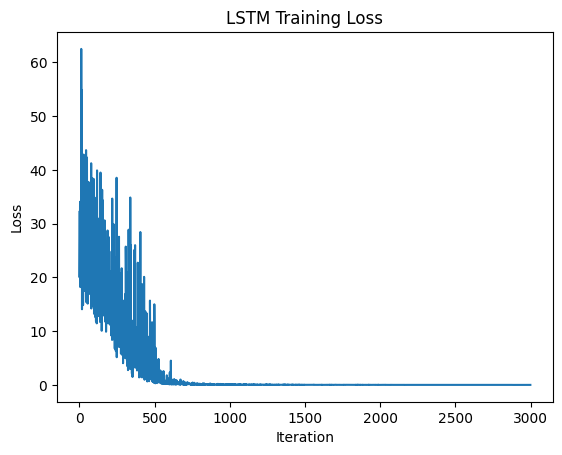


Sampling for category: China
 Step 1: predicted character='B'
 Step 2: predicted character='e'
 Step 3: predicted character='i'
 Step 4: predicted character='j'
 Step 5: predicted character='i'
 Step 6: predicted character='n'
 Step 7: predicted character='g'
 Step 8: EOS encountered, stopping sampling
Generated name: Beijing


Sampling for category: Germany
 Step 1: predicted character='B'
 Step 2: predicted character='e'
 Step 3: predicted character='r'
 Step 4: predicted character='l'
 Step 5: predicted character='i'
 Step 6: predicted character='n'
 Step 7: EOS encountered, stopping sampling
Generated name: Berlin


Sampling for category: Argentina
 Step 1: predicted character='B'
 Step 2: predicted character='u'
 Step 3: predicted character='e'
 Step 4: predicted character='n'
 Step 5: predicted character='o'
 Step 6: predicted character='s'
 Step 7: predicted character=' '
 Step 8: predicted character='A'
 Step 9: predicted character='i'
 Step 10: predicted character='r'
 Step 1

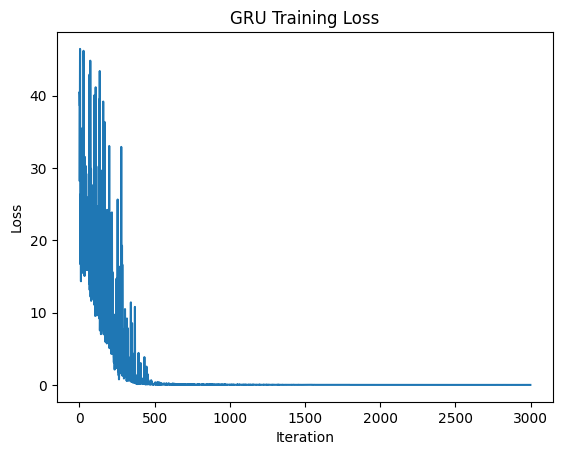


Sampling for category: Italy
 Step 1: predicted character='R'
 Step 2: predicted character='o'
 Step 3: predicted character='m'
 Step 4: predicted character='e'
 Step 5: EOS encountered, stopping sampling
Generated name: Rome


Sampling for category: Norway
 Step 1: predicted character='O'
 Step 2: predicted character='s'
 Step 3: predicted character='l'
 Step 4: predicted character='o'
 Step 5: EOS encountered, stopping sampling
Generated name: Oslo


Sampling for category: Mexico
 Step 1: predicted character='M'
 Step 2: predicted character='e'
 Step 3: predicted character='x'
 Step 4: predicted character='i'
 Step 5: predicted character='c'
 Step 6: predicted character='o'
 Step 7: predicted character=' '
 Step 8: predicted character='C'
 Step 9: predicted character='i'
 Step 10: predicted character='t'
 Step 11: predicted character='y'
 Step 12: EOS encountered, stopping sampling
Generated name: Mexico City


Starting RNN experiment with prints
Training step: category=Australia, i

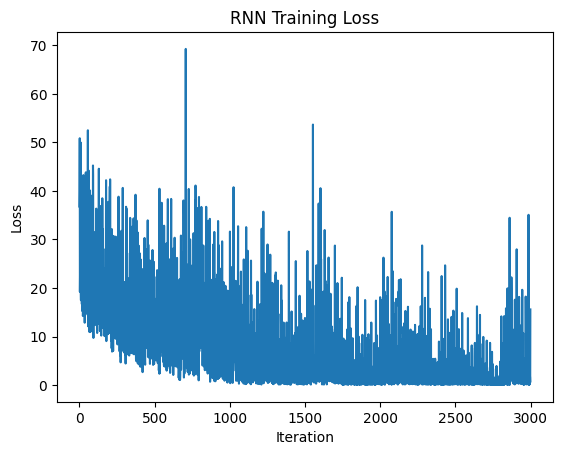


Sampling for category: Sweden
 Step 1: predicted character='S'
 Step 2: predicted character='t'
 Step 3: predicted character='h'
 Step 4: predicted character='c'
 Step 5: predicted character='n'
 Step 6: predicted character='s'
 Step 7: predicted character=' '
 Step 8: predicted character='C'
 Step 9: predicted character='i'
 Step 10: predicted character='t'
 Step 11: predicted character='e'
 Step 12: predicted character='s'
 Step 13: predicted character='c'
 Step 14: predicted character='s'
 Step 15: predicted character=' '
 Step 16: predicted character='C'
 Step 17: predicted character='m'
 Step 18: predicted character='t'
 Step 19: predicted character='e'
 Step 20: predicted character='s'
Generated name: Sthcns Citescs Cmtes


Sampling for category: Ukraine
 Step 1: predicted character='K'
 Step 2: predicted character='y'
 Step 3: predicted character='i'
 Step 4: predicted character='v'
 Step 5: EOS encountered, stopping sampling
Generated name: Kyiv


Sampling for category: Norway

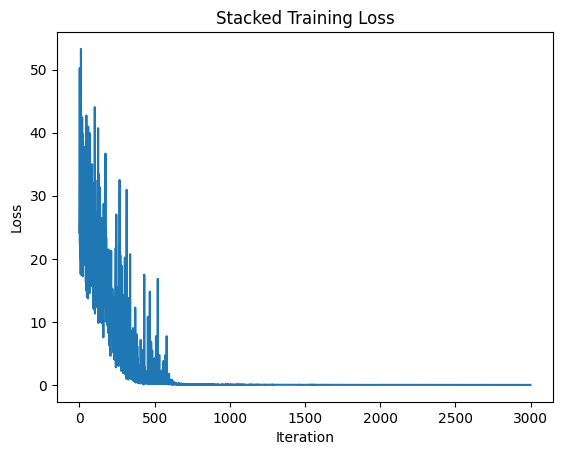


Sampling for category: Sweden
 Step 1: predicted character='S'
 Step 2: predicted character='t'
 Step 3: predicted character='o'
 Step 4: predicted character='c'
 Step 5: predicted character='k'
 Step 6: predicted character='h'
 Step 7: predicted character='o'
 Step 8: predicted character='l'
 Step 9: predicted character='m'
 Step 10: EOS encountered, stopping sampling
Generated name: Stockholm


Sampling for category: Ukraine
 Step 1: predicted character='K'
 Step 2: predicted character='y'
 Step 3: predicted character='i'
 Step 4: predicted character='v'
 Step 5: EOS encountered, stopping sampling
Generated name: Kyiv


Sampling for category: Kenya
 Step 1: predicted character='N'
 Step 2: predicted character='a'
 Step 3: predicted character='i'
 Step 4: predicted character='r'
 Step 5: predicted character='o'
 Step 6: predicted character='b'
 Step 7: predicted character='i'
 Step 8: EOS encountered, stopping sampling
Generated name: Nairobi




In [67]:
import torch
import torch.nn as nn
import random
import string
import matplotlib.pyplot as plt

# =============================
# 1. Dataset: Country -> Capital City
# =============================
country_to_city = {
    "France": "Paris", "Japan": "Tokyo", "Brazil": "Brasialia", "Egypt": "Cairo",
    "Germany": "Berlin", "Italy": "Rome", "Canada": "Ottawa", "India": "New Delhi",
    "Australia": "Canberra", "Ukraine": "Kyiv", "Spain": "Madrid", "Mexico": "Mexico City",
    "China": "Beijing", "Turkey": "Ankara", "Argentina": "Buenos Aires", "Kenya": "Nairobi",
    "Norway": "Oslo", "Sweden": "Stockholm", "Greece": "Athens", "Thailand": "Bangkok"
}
categories = list(country_to_city.keys())

# =============================
# 2. Character Set + Special Tokens
# =============================
all_letters = string.ascii_letters + " -"
SOS_token = 0
EOS_token = 1
letter_list = list(all_letters)
n_letters = len(letter_list) + 2  # + SOS, EOS
n_categories = len(categories)

# Mappings
letter_to_idx = {ch: i+2 for i, ch in enumerate(letter_list)}
idx_to_letter = {i+2: ch for i, ch in enumerate(letter_list)}
idx_to_letter[SOS_token] = '<SOS>'
idx_to_letter[EOS_token] = '<EOS>'

category_to_idx = {cat: i for i, cat in enumerate(categories)}

# =============================
# 3. Tensor conversion helpers
# =============================
def letter_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0, letter_to_idx.get(letter, EOS_token)] = 1
    return tensor

def category_tensor(cat):
    tensor = torch.zeros(1, n_categories)
    tensor[0, category_to_idx[cat]] = 1
    return tensor

def line_tensors(line):
    inputs = [letter_tensor('<SOS>')]
    for ch in line:
        inputs.append(letter_tensor(ch))
    inputs.append(letter_tensor('<EOS>'))
    return inputs[:-1], inputs[1:]

# =============================
# 4. RNN Model Variants
# =============================
class CharRNN(nn.Module):
    def __init__(self, rnn_type='LSTM', input_size=n_letters+n_categories,
                 hidden_size=128, output_size=n_letters, num_layers=2):
        super().__init__()
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers)
        else:
            self.rnn = nn.RNN(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size

    def forward(self, inp, hidden):
        out, hidden = self.rnn(inp, hidden)
        out = self.fc(out.squeeze(0))
        return out, hidden

    def init_hidden(self):
        weight = next(self.parameters())
        if self.rnn_type == 'LSTM':
            return (weight.new_zeros(self.num_layers, 1, self.hidden_size),
                    weight.new_zeros(self.num_layers, 1, self.hidden_size))
        else:
            return weight.new_zeros(self.num_layers, 1, self.hidden_size)

# =============================
# 5. Training Function for Simple RNNs
# =============================
def train(model, category, line, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    hidden = model.init_hidden()
    inp_seq, tgt_seq = line_tensors(line)
    loss = 0
    for inp, tgt in zip(inp_seq, tgt_seq):
        combined = torch.cat([inp, category_tensor(category)], dim=1)
        output, hidden = model(combined.unsqueeze(0), hidden)
        pred_idx = output.argmax(dim=1).item()
        pred_char = idx_to_letter[pred_idx]
        true_char = idx_to_letter[tgt.argmax().item()]
        print(f"Training step: category={category}, input={idx_to_letter[inp.argmax().item()]}, predicted={pred_char}, target={true_char}")
        loss += criterion(output, tgt.argmax(dim=1))
    loss.backward()
    optimizer.step()
    print(f"Training loss: {loss.item():.4f}")
    return loss.item()

# =============================
# 6. Sampling Function
# =============================
def sample(model, category, max_len=20):
    model.eval()
    hidden = model.init_hidden()
    inp = letter_tensor('<SOS>')
    name = ''
    print(f"\nSampling for category: {category}")
    with torch.no_grad():
        for step in range(1, max_len+1):
            combined = torch.cat([inp, category_tensor(category)], dim=1)
            output, hidden = model(combined.unsqueeze(0), hidden)
            top_i = output.argmax(dim=1).item()
            if top_i == EOS_token:
                print(f" Step {step}: EOS encountered, stopping sampling")
                break
            ch = idx_to_letter[top_i]
            print(f" Step {step}: predicted character='{ch}'")
            name += ch
            inp = letter_tensor(ch)
    print(f"Generated name: {name}\n")
    return name

# =============================
# 7. Stacked RNN: LSTM followed by GRU
# =============================
class StackedRNN(nn.Module):
    def __init__(self, input_size=n_letters+n_categories, hidden_size=128, output_size=n_letters):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=1)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, inp, hidden):
        (h_l, c_l) = hidden['lstm']
        out_l, (h_l, c_l) = self.lstm(inp, (h_l, c_l))
        out_g, h_g = self.gru(out_l, hidden['gru'])
        out = self.fc(out_g.squeeze(0))
        new_hidden = {'lstm': (h_l, c_l), 'gru': h_g}
        return out, new_hidden

    def init_hidden(self):
        weight = next(self.parameters())
        return {
            'lstm': (weight.new_zeros(1,1,128), weight.new_zeros(1,1,128)),
            'gru': weight.new_zeros(1,1,128)
        }

# =============================
# 8. Training Function for StackedRNN
# =============================
def train_stacked(model, category, line, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    hidden = model.init_hidden()
    inp_seq, tgt_seq = line_tensors(line)
    loss = 0
    for inp, tgt in zip(inp_seq, tgt_seq):
        combined = torch.cat([inp, category_tensor(category)], dim=1)
        output, hidden = model(combined.unsqueeze(0), hidden)
        pred_idx = output.argmax(dim=1).item()
        pred_char = idx_to_letter[pred_idx]
        true_char = idx_to_letter[tgt.argmax().item()]
        print(f"Stacked training: category={category}, input={idx_to_letter[inp.argmax().item()]}, predicted={pred_char}, target={true_char}")
        loss += criterion(output, tgt.argmax(dim=1))
    loss.backward()
    optimizer.step()
    print(f"Stacked training loss: {loss.item():.4f}")
    return loss.item()

# =============================
# 9. Experiments
# =============================
def run_experiment(rnn_type='LSTM', epochs=3000, lr=0.005):
    model = CharRNN(rnn_type) if rnn_type in ['LSTM','GRU','RNN'] else StackedRNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_fn = train if rnn_type in ['LSTM','GRU','RNN'] else train_stacked
    print(f"Starting {rnn_type} experiment with prints")
    losses = []
    for it in range(1, epochs+1):
        cat = random.choice(categories)
        line = country_to_city[cat]
        if it % 500 == 0:
            print(f"Experiment {rnn_type}, iteration {it}/{epochs}")
        loss = train_fn(model, cat, line, criterion, optimizer)
        losses.append(loss)

    plt.figure()
    plt.plot(losses)
    plt.title(f"{rnn_type} Training Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()

    for cat in random.sample(categories, 3):
        sample(model, cat)
    print(""*40)

# =============================
# 10. Run All Experiments
# =============================
if __name__ == '__main__':
    for arch in ['LSTM','GRU','RNN','Stacked']:
        run_experiment(arch)

In [64]:
import torch
import torch.nn as nn
import random
import string

# Малий датасет: Country -> Capital
country_to_city = {
    "France": "Paris", "Japan": "Tokyo", "Brazil": "Brasília",
    "Egypt": "Cairo", "Canada": "Ottawa", "India": "New Delhi"
}

# Символи та токени
all_letters = string.ascii_letters + " -"
SOS_token = 0
EOS_token = 1
letter_list = list(all_letters)
n_letters = len(letter_list) + 2
n_categories = len(country_to_city)

# Мапінг
letter_to_idx = {ch: i+2 for i, ch in enumerate(letter_list)}
idx_to_letter = {i+2: ch for i, ch in enumerate(letter_list)}
idx_to_letter[SOS_token] = '<SOS>'
idx_to_letter[EOS_token] = '<EOS>'
category_to_idx = {cat: i for i, cat in enumerate(country_to_city.keys())}

# Тензори
def letter_tensor(ch):
    t = torch.zeros(1, n_letters)
    t[0, letter_to_idx.get(ch, EOS_token)] = 1
    return t

def category_tensor(cat):
    t = torch.zeros(1, n_categories)
    t[0, category_to_idx[cat]] = 1
    return t

def line_tensors(line):
    inputs = [letter_tensor('<SOS>')] + [letter_tensor(c) for c in line] + [letter_tensor('<EOS>')]
    return inputs[:-1], inputs[1:]

# Проста LSTM-модель
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size

    def forward(self, inp, hidden):
        out, hidden = self.lstm(inp, hidden)
        out = self.fc(out.squeeze(0))
        return out, hidden

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))

# Навчання лише 200 ітерацій з маленьким hidden_size
hidden_size = 16
model = SimpleLSTM(n_letters + n_categories, hidden_size, n_letters)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Тренувальний цикл
for i in range(200):
    cat = random.choice(list(country_to_city.keys()))
    city = country_to_city[cat]
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0
    inputs, targets = line_tensors(city)
    for inp, tgt in zip(inputs, targets):
        combined = torch.cat([inp, category_tensor(cat)], dim=1).unsqueeze(0)
        output, hidden = model(combined, hidden)
        loss += criterion(output, tgt.argmax(dim=1))
    loss.backward()
    optimizer.step()

# Семплінг після малої кількості ітерацій
print("Після 200 ітерацій (hidden_size=16):")
for cat in country_to_city.keys():
    hidden = model.init_hidden()
    inp = letter_tensor('<SOS>')
    name = ''
    for _ in range(20):
        combined = torch.cat([inp, category_tensor(cat)], dim=1).unsqueeze(0)
        out, hidden = model(combined, hidden)
        top_i = out.argmax(dim=1).item()
        if top_i == EOS_token: break
        ch = idx_to_letter[top_i]
        name += ch
        inp = letter_tensor(ch)
    print(f"{cat} -> {name}")


Після 200 ітерацій (hidden_size=16):
France -> Pais
Japan -> Tokyo
Brazil -> Bars
Egypt -> Bais
Canada -> Otttawa
India -> New Delhi
